# Graph Building

In [1]:
import json
import nltk
import networkx as nx
import pickle
from sentence_transformers import SentenceTransformer, util
import re

## 1.) Story Graphs

The first step of building a knowledge graph from the GLUCOSE dataset is to build a graph for every story.

Therefore we first load the story data into memory:

In [2]:
with open('../data/story_data_final_coref.json','r') as f:
        stories = json.load(f)
print('loaded ',len(stories), ' stories from "../data/story_data_final_coref.json"')

loaded  4584  stories from "../data/story_data_final_coref.json"


and the embedding data, too:

In [3]:
with open('../data/embeddings.pkl', "rb") as f:
    stored_data = pickle.load(f)
    embedding_map = dict(zip(stored_data['sentences'],stored_data['embeddings']))
print('Loaded ', len(embedding_map), ' embeddings')

add = {}
for sent in embedding_map.keys():
    if '  ' in sent:
        add[sent.replace('  ',' ')] = embedding_map[sent]
embedding_map.update(add)
#embedding_map = {key.replace('  ',' '):val for (key,val) in embedding_map.items()}

Loaded  680522  embeddings


### 1.1.) Sentence Nodes

Each story consists of 1 to 6 sentences. In the following we will process only stories with 5 sentences. Each sentence will be represented by a sentence node. Since the sentence index is included in the annotations we can fill these sentence nodes with the information we get from the annotations.

A sentence node has the following attributes:

1. name = index 
2. sentence: a list of sentence and if unequal corref resolved sentence
3. nl_rep: a list of natural language representations for sentence extracted from annotations

In [4]:
def make_sentence_nodes(story):
    
    graph = nx.DiGraph()
    plain_story = nltk.sent_tokenize(story['story'])
    resolved_story = nltk.sent_tokenize(story['resolved_story'])
    
    # make sentence nodes
    for i, sentence in enumerate(plain_story):
        graph.add_node(i, sentence = [sentence], nl_rep = [])

        # add resolved sentence to node if it differs from original
        if len(plain_story)==len(resolved_story) and sentence.lower() != resolved_story[i].lower():
            graph.nodes[i]['sentence'].append(resolved_story[i])
            
    return(graph)


def fill_sentence_nodes(annotations, graph):
    
    for annotation in annotations:
        sent_index = annotation['sent_index']
        for dimension in annotation['dimensions']:
            rule_0 = annotation['dimensions'][dimension][0]
            rule_2 = annotation['dimensions'][dimension][2]
            if int(dimension) < 6:
                index = 2
            else:
                index = 0
            if rule_0[index] not in graph.nodes[sent_index]['nl_rep'] and rule_0[index] not in graph.nodes[sent_index]['sentence']:
                graph.nodes[sent_index]['nl_rep'].append(rule_0[index])
                
            #print(annotation['dimensions'][dimension])
            
            #annotation_info = {'quality':annotation['quality'], 'sent_index':sent_index, 'edge_to':None,
                               #'dim':int(dimension), 'annotation':annotation['dimensions'][dimension]}
            #if annotation_info not in graph.nodes[sent_index]['annotations']:
                #graph.nodes[sent_index]['annotations'].append(annotation_info)
            #graph.nodes[sent_index]['freq'] += 1
    return(graph)

As an example for one story we now create the sentence nodes and then fill them with the information obtained by the annotations:

story:

Today my dad took me and my brothers to the zoo. We liked looking at the animals. We rode a camel and a horse. My brothers got to pet a monkey but I was scared. My dad said that we will get to go again very soon. 


expressions from annotations:

Sentence Node  0 :
['Today my dad took me and my brothers to the zoo.'] 

['My dad takes me & my brothers to the zoo', 'My dad brought me & my brothers to the zoo', 'My dad brings me and my brothers to the zoo', 'My dad takes me & my brothers next to the zoo', 'My dad brings me & my brothers to the zoo', 'My Dad took me and my brothers to the zoo', 'Today my Dad took me and my brothers to the zoo', 'they visit zoo', 'they rode camel and horse'] 

Sentence Node  1 :
['We liked looking at the animals.'] 

['We liked looking at the animals', 'We like looking at the animals', 'We liked looking at the animals in the zoo'] 

Sentence Node  2 :
['We rode a camel and a horse.'] 

['We rode a camel and a horse', 'We rode a camel and a horse to'

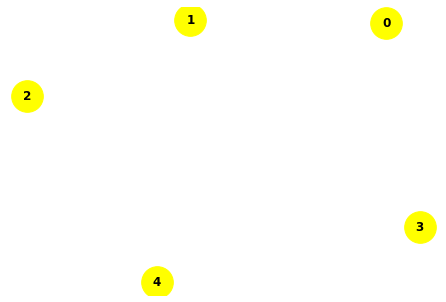

In [5]:
story = stories[53]
graph = make_sentence_nodes(story)
graph = fill_sentence_nodes(story['annotations'], graph)

nx.draw(graph, with_labels=True, font_weight='bold', node_color='yellow', node_size=1000)

print('story:\n')
print(story['story'],'\n\n')
print('expressions from annotations:\n')
for node in list(graph.nodes):
    print('Sentence Node ',node,':')
    print(graph.nodes[node]['sentence'],'\n')
    print(graph.nodes[node]['nl_rep'],'\n')

#for anno in story['annotations']:
    #for dim in anno['dimensions']:
        #for rule in anno['dimensions'][dim]:
            #print(rule)
        #print('\n')

Let's have a look at the annotations of the first sentence:

    ['My dad takes me & my brothers to the zoo', 'My dad brought me & my brothers to the zoo', 'My dad brings me and my brothers to the zoo', 'My dad takes me & my brothers next to the zoo', 'My dad brings me & my brothers to the zoo', 'My Dad took me and my brothers to the zoo', 'Today my Dad took me and my brothers to the zoo', 'they visit zoo', 'they rode camel and horse']
    
The last expression 'they rode camel and horse' should not be linked to the first but to the third sentence.

There are other mislinks like that.

This leaves us in an uncomfortable situation, since we actually want one node representing one sentence of the story. Semantic similarity is the fundament for our graph building process.

At this point we could just ignore the problem and hope that these 'false' expressions will get overshadowed by the rest or we could check for semantic similarity before we add an expression to a sentence node.

Let's rewrite the code and add an expression to a sentence node only if it is semantically similar to the representation of that node.

To compute semantic similarity between two expressions, we compute the cosine similatity between their embeddings:

In [6]:
def check_cosine_similarity(sentence_list, sentence, cos_value):
    sent_embedding = embedding_map[sentence.replace('  ',' ')] #HERE
    list_embedding = [embedding_map[sent.replace('  ',' ')] for sent in sentence_list] #HERE
    cosines = util.pytorch_cos_sim(list_embedding, sent_embedding)
    if max(cosines)>= cos_value:
        return(True)
    else:
        return(False)

For our purpose we set the cosine similarity to 0.5 and add only if the requirement is true:

In [7]:
def make_sentence_nodes(story):
    
    graph = nx.DiGraph()
    plain_story = nltk.sent_tokenize(story['story'])
    resolved_story = nltk.sent_tokenize(story['resolved_story'])
    
    # make sentence nodes
    for i, sentence in enumerate(plain_story):
        graph.add_node(i, sentence = [sentence], nl_rep = [])

        # add resolved sentence to node if it differs from original
        if len(plain_story)==len(resolved_story) and sentence.lower() != resolved_story[i].lower():
            graph.nodes[i]['sentence'].append(resolved_story[i])
            
    return(graph)

def split_sentence(sentence_list):
    sentence_split = []
    for sentence in sentence_list:
        if ', ' in sentence:
            sentence_split += sentence.split(', ')
        if ' and ' in sentence:
            sentence_split += sentence.split(' and ')
        if ' and ' in sentence and ', ' in sentence:
            sentence_split += re.split(', | and ', sentence)
    return(list(set(sentence_split)))

def fill_sentence_nodes(annotations, graph):
    
    left = []
    
    for i, annotation in enumerate(annotations):
        delete = []
        sent_index = annotation['sent_index']
        for dimension in annotation['dimensions']:
            rule_0 = [el.replace('(','').replace(')','') for el in annotation['dimensions'][dimension][0]]
            #rule_0 = annotation['dimensions'][dimension][0] #HEREHERE
            rule_2 = annotation['dimensions'][dimension][2]
            if int(dimension) < 6:
                index = 2
            else:
                index = 0
            check = False
            # check cosine similarity between annotated sentence and story sentence
            if check_cosine_similarity(graph.nodes[sent_index]['nl_rep']+graph.nodes[sent_index]['sentence'], 
                                       rule_0[index], 0.5):
                check = True
            # check if annotated sentence is subsentence of story sentence
            if check == False:
                sentence_split = split_sentence(graph.nodes[sent_index]['sentence'])
                if len(sentence_split)!= 0:
                    check = check_cosine_similarity(sentence_split, rule_0[index], 0.7)
            # check if annotated sentence belongs to one of the other story sentences    
            if check == False:
                story_sents = [graph.nodes[node]['sentence'][0] for node in graph.nodes]
                list_embedding = [embedding_map[sent.replace('  ',' ')] for sent in story_sents] #HERE
                sent_embedding = embedding_map[rule_0[index].replace('  ',' ')] #HERE
                cosines = list(util.pytorch_cos_sim(list_embedding, sent_embedding))
                if max(cosines)>=0.5:
                    sent_index = cosines.index(max(cosines))
                    annotations[i]['sent_index'] = sent_index
                    check = True
            # if one of the above is true, fill sentence node with annotation    
            if check == True:
                #if rule_2[index] not in graph.nodes[sent_index]['abstr_rep']:
                    #graph.nodes[sent_index]['abstr_rep'].append(rule_2[index])
                if rule_0[index] not in graph.nodes[sent_index]['nl_rep'] and rule_0[index] not in graph.nodes[sent_index]['sentence']:
                    graph.nodes[sent_index]['nl_rep'].append(rule_0[index])
                #annotation_info = {'quality':annotation['quality'], 'sent_index':sent_index, 'dim':int(dimension), 
                                   #'edge_to':None, 'annotation':annotation['dimensions'][dimension]}
                #if annotation_info not in graph.nodes[sent_index]['annotations']:
                    #graph.nodes[sent_index]['annotations'].append(annotation_info)
                #graph.nodes[sent_index]['freq'] += 1
            # else delete annotation    
            else:
                info = {'expression':rule_0[index], 'sentence':graph.nodes[sent_index]['sentence'][0],
                        'sent_index':sent_index,'quality':annotation['quality']}
                left.append(info)
                delete.append(dimension)
        annotations_dimensions = {k:v for (k,v) in annotation['dimensions'].items() if k not in delete}
        annotations[i]['dimensions'] = annotations_dimensions
                
    return(graph,annotations,left)

In [8]:
story = stories[53]
graph = make_sentence_nodes(story)
graph,story['annotations'], left = fill_sentence_nodes(story['annotations'], graph)

print('These expressions were not added to the graph:\n')
for el in left:
    for k in el.keys():
        print(k,':\t', el[k])
    print('-'*20)

These expressions were not added to the graph:

expression :	 they are happy
sentence :	 My dad said that we will get to go again very soon.
sent_index :	 4
quality :	 2
--------------------
expression :	 they feel happy
sentence :	 My dad said that we will get to go again very soon.
sent_index :	 4
quality :	 2
--------------------
expression :	 I do not pet the monkey
sentence :	 My brothers got to pet a monkey but I was scared.
sent_index :	 3
quality :	 2
--------------------


We see that in this case a cosine similarity check of 0.5 filters all 'faulty' annotations. Further we see that these annotations all have quality 2.

At this point the question arises if we rather want a smaller graph with good quality annotations or a bigger one with possibly noisy annotations.

For now we just skip the annotations that don't match a cosine similarity of 0.5 or higher and continue building our graph.

### 1.2.) Edges between Sentence Nodes

Now that we created a node for every sentence we are interessted if there are annotated relations (edges) between these sentence nodes.

Therefore for every annotated rule we try to match the part without index reference to a sentence node. We do this by computing the cosine similarity between the expression and the sentence node representation and add the expression if the score is 0.8 or higher.


0 .)  Today my dad took me and my brothers to the zoo.
1 .)  We liked looking at the animals.
2 .)  We rode a camel and a horse.
3 .)  My brothers got to pet a monkey but I was scared.
4 .)  My dad said that we will get to go again very soon.
{3: [[['We are at the zoo', 'Enables', 2], {'dimension': '3', 'quality': 2, 'worker_id': 8, 'rules': [['We are at the zoo', 'Enables', 'We rode a camel and a horse.'], ['{We}_[subject] {are}_[verb] {at}_[preposition] {the zoo}_[object]', 'Enables', '{We}_[subject] {rode}_[verb] {a camel and a horse. }_[object1]'], ['Someone_A and Someone_B are at Somewhere_A ((which is the zoo))', 'Enables', 'Someone_A and Someone_B rode Something_A and Something_B ((whiich are animals))'], ['{Someone_A and Someone_B}_[subject] {are}_[verb] {at}_[preposition] {Somewhere_A ||(which is the zoo)||}_[object]', 'Enables', '{Someone_A and Someone_B}_[subject] {rode}_[verb] {Something_A and Something_B ||(whiich are animals)||}_[object1]']]}], [['My family is at the zoo'

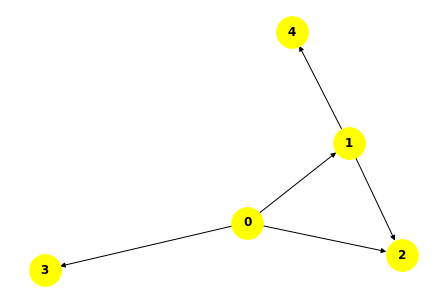

In [9]:
def find_opposite_sentence_nodes(annotations, graph):
    
    left_overs = {}
    for annotation in annotations:
        # story sentence index for annotation
        sent_index = annotation['sent_index']
        # annotated dimensions
        dimensions = annotation['dimensions']
        for dimension in dimensions:
            info = {'dimension':dimension, 'quality':annotation['quality'], 'worker_id':annotation['worker_id'],
                    'rules':dimensions[dimension]} 
            success = False
            
            if int(dimension) < 6:
                index = 0
            else:
                index = 2
                
            nl_rep = [el.replace('(','').replace(')','') for el in dimensions[dimension][0]]
            
            cosines = []
            sent_embedding =  embedding_map[nl_rep[index].replace('  ',' ')] #HERE
            for node in list(graph.nodes):
                # dont't match the sentence node of other side of rule
                if node == sent_index:
                    cosines.append(0.0)
                    continue
                    
                original_sent_embedding = [embedding_map[s.replace('  ',' ')] for s in graph.nodes[node]['sentence']] #HERE
                cos = max(util.pytorch_cos_sim(original_sent_embedding, sent_embedding))
                if cos>=0.9:
                    cosines.append(cos)
                else:
                    node_embedding = [embedding_map[sent.replace('  ',' ')] for sent in graph.nodes[node]['nl_rep'] #HERE
                                      +graph.nodes[node]['sentence']]
                    cosines.append(sum(util.pytorch_cos_sim(node_embedding, sent_embedding))/len(node_embedding))
            
            if max(cosines)>0.8:
                node = cosines.index(max(cosines))
                
                if index == 0:
                    out_node, in_node = node, sent_index
                else:
                    out_node, in_node = sent_index, node
                    
                if (out_node, in_node) not in list(graph.edges):
                    graph.add_edge(out_node, in_node, annotations = [info])
                else:
                    graph.edges[(out_node, in_node)]['annotations'].append(info)    
                
                if nl_rep[index] not in graph.nodes[node]['sentence']+graph.nodes[node]['nl_rep']:
                    graph.nodes[node]['nl_rep'].append(nl_rep[index])
                   
                success = True
                    
            # append to left_overs
            if success == False:
                if index == 0:
                    nl_rep = [nl_rep[0], nl_rep[1], sent_index]
                    #rule_2 = [rule_2[0], rule_2[1], sent_index]
                else:
                    nl_rep = [sent_index, nl_rep[1], nl_rep[2]]
                    #rule_2 = [sent_index, rule_2[1], rule_2[2]]
                #annotation_info = {'quality':annotation['quality'],'sent_index':sent_index, 'dim':dimension,
                                   #'annotation':dimensions[dimension]}
                annotation_info = [nl_rep, info]
                if int(dimension) not in left_overs.keys():
                    left_overs[int(dimension)] = []
                    left_overs[int(dimension)].append(annotation_info)
                else:
                    left_overs[int(dimension)].append(annotation_info)
    return(graph, left_overs)

graph, left_overs = find_opposite_sentence_nodes(story['annotations'], graph)

for i, sent in enumerate(nltk.sent_tokenize(story['story'])):
    print(i,'.) ', sent)

nx.draw(graph, with_labels=True, font_weight='bold', node_color='yellow', node_size=1000)

print(left_overs)

At this point we created a graph only from the stories sentences. We could stop here and inspect the graphs, for example for rule chains and others. 

But for know we continue in adding also the annotated sentences to the graph:

### 1.3.) New Nodes and their Edges

The unmapped annotations left don't describe a relation between sentence nodes but a relation between one sentence node and a new annotated expression.

We now want to create nodes that represent new concepts. 

Therefore we cluster the remaining expressions if their cosine similarity is 0.8 or higher.

In [10]:
def cluster_left_overs(left_overs, min_cos=0.9):
    cluster_per_dimension = []
    left_over_list = []   
    dimension_pairs = [(1,6),(2,7),(3,8),(4,9),(5,10)]
    for (x,y) in dimension_pairs:
        if x in left_overs.keys() and y in left_overs.keys():
            left_over_list.append({x:left_overs[x],y:left_overs[y]})
        elif x in left_overs.keys():
            left_over_list.append({x:left_overs[x]})
        elif y in left_overs.keys():
            left_over_list.append({y:left_overs[y]})
        else:
            left_over_list.append(None)
        
    
    for left_over in left_over_list:
        if left_over==None:
            cluster_per_dimension.append(None)
            continue
        # extract sentences to be clustered
        sentences = []
        for dimension in left_over:
            if dimension<6:
                for rule in left_over[dimension]:
                    sentences.append(rule[0][0])
            else:
                for rule in left_over[dimension]:
                    sentences.append(rule[0][2])
        #print(sentences)
    
        clusters = []
        while len(sentences)>1:
            cluster = []
            sent = sentences[0]

            # check for string matching
            for i, s in enumerate(sentences):
                if s == sent:
                    cluster.append(sentences[i])
            sentences = [s for s in sentences if s!=sent]

            # check cosine similarity
            delete = []
            sent_embedding = embedding_map[sent.replace('  ',' ')] #HERE
            sents_embeddings = [embedding_map[sent.replace('  ',' ')] for sent in sentences] #HERE
            if len(sentences)>0:
                cosine = util.pytorch_cos_sim(sents_embeddings, sent_embedding)
                for i, cos in enumerate(cosine):
                    if cos > min_cos:
                        cluster.append(sentences[i])
                        delete.append(i)
                sentences = [sent for i, sent in enumerate(sentences) if i not in delete]
            clusters.append(cluster)

        if len(sentences)==1:
            clusters.append([sentences[0]])
        cluster_per_dimension.append(clusters)
    return(cluster_per_dimension)
    
cluster_per_dimension = cluster_left_overs(left_overs)
print('These are the clusters of the remaining expressions:\n')
for clusters in cluster_per_dimension:
    for cluster in clusters:
        print(cluster)
    print('#'*10)

These are the clusters of the remaining expressions:

['Me and my family enjoy going to the zoo']
['My dad, my brothers & I go on an outing']
['they visit zoo']
['We go to the zoo']
##########
['My family feels happy']
['My family wants to see the animals in the zoo']
['We feels curiosity']
['We like the animals']
['My dad likes the zoo']
['We feels happy', 'We feels happy', 'We feels happy', 'We feels happy', 'We feels entertained', 'I feels happy']
['I feels too scared to pet the monkey']
['I feels stressed']
##########
['We are at the zoo', 'We are at the zoo', 'We are at the zoo', 'We are at the zoo', 'We are at the zoo', 'We are at the zoo', 'they are at zoo', 'they are at zoo']
['My family is at the zoo']
['My dad, my brothers & I are at the zoo']
['We are among the animals']
##########
['My dad possesses tickets to the zoo']
['The zoo possesses animals']
['My brothers & I possesses rides on a camel & a horse']
##########
['My brothers & I wants to see the animals']
['We wants to

For every cluster we now create a new event node and it's edges:

0
{'sentence': ['Today my dad took me and my brothers to the zoo.'], 'nl_rep': ['My dad takes me & my brothers to the zoo', 'My dad brought me & my brothers to the zoo', 'My dad brings me and my brothers to the zoo', 'My dad takes me & my brothers next to the zoo', 'My dad brings me & my brothers to the zoo', 'My Dad took me and my brothers to the zoo', 'Today my Dad took me and my brothers to the zoo', 'they visit zoo', 'they went to zoo', 'My dad took my brothers and I to the zoo', 'my dad took me and my brothers the zoo', 'My dad takes me and my brothers to the zoo']}
----------
1
{'sentence': ['We liked looking at the animals.'], 'nl_rep': ['We liked looking at the animals', 'We like looking at the animals', 'We liked looking at the animals in the zoo', 'they likes animals']}
----------
2
{'sentence': ['We rode a camel and a horse.'], 'nl_rep': ['We rode a camel and a horse', 'We rode a camel and a horse to', 'they rode camel and horse', 'they rode horse and camel']}
----------
3
{

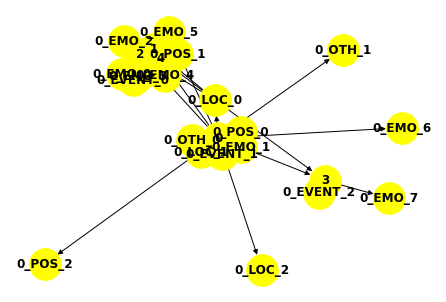

In [11]:
def mk_new_event_nodes(graph, left_overs, story_id):
    
    cluster_per_dimension = cluster_left_overs(left_overs, min_cos=0.8)
    dim_dict = {1:'EVENT', 2:'EMO',3:'LOC',4:'POS',5:'OTH',6:'EVENT', 7:'EMO',8:'LOC',9:'POS',10:'OTH'}
    
    
    for clusters in cluster_per_dimension:
        
        if clusters==None:
            continue
            
        prefix = dim_dict[cluster_per_dimension.index(clusters)+1]
        node_index = 0
            
        for cluster in clusters:
            
            #mk_node
            cluster_node = str(story_id)+'_'+prefix+'_'+str(node_index)
            graph.add_node(cluster_node, nl_rep=list(set(cluster)))
            
            for dimension in left_overs:
                if dimension<6:
                    index, index_2 = 0, 2
                else:
                    index, index_2 = 2, 0
                rules = left_overs[dimension]
                for rule in rules:
                    nl_rep = rule[0][index]
                    if nl_rep in cluster:
                        if index==0:
                            out_node, in_node = cluster_node, rule[0][index_2]
                        else:
                            out_node, in_node = rule[0][index_2], cluster_node
                        
                        if (out_node, in_node) not in list(graph.edges):
                            graph.add_edge(out_node, in_node, annotations = [rule[1]])
                        else:
                            graph.edges[(out_node, in_node)]['annotations'].append(rule[1])
            node_index += 1
            
    return(graph)

graph = mk_new_event_nodes(graph, left_overs, 0)
nx.draw(graph, with_labels=True, font_weight='bold', node_color='yellow', node_size=1000)

for node in graph.nodes:
    print(node)
    print(graph.nodes[node])
    print('-'*10)
    
print('#'*20)

for edge in graph.edges:
    print(edge)
    print(graph.edges[edge])
    print('-'*10)

We also want to create a story node, that represents the whole story, and that relates to all sentence nodes.

The story node has the attributes:

- story
- resolved story
- cluster label

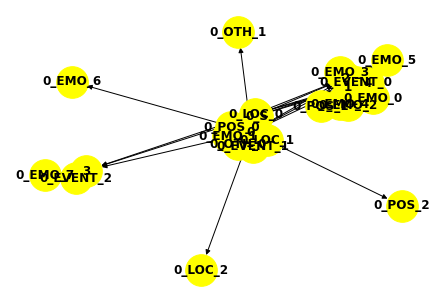

In [12]:
def mk_story_node(graph, story, story_id):
    
    graph.add_node(str(story_id)+'_S', story = story['story'], resolved_story = story['resolved_story'], 
                   cluster = story['cluster'])
    for node in list(graph.nodes):
        if type(node)==int:
            graph.add_edge(str(story_id)+'_S', node)
    return graph
    

graph = mk_story_node(graph, story, 0)
nx.draw(graph, with_labels=True, font_weight='bold', node_color='yellow', node_size=1000)

#print(graph.edges)

At last we rename the sentence nodes in adding the story_id for later convenience.

In [13]:
def rename_sentence_nodes(graph, story_id):
    to_rename = [node for node in list(graph.nodes) if type(node)==int]
    name_map = {node:str(story_id)+'_'+str(node) for node in to_rename}
    graph = nx.relabel_nodes(graph, name_map, copy=False)
    return(graph)
graph = rename_sentence_nodes(graph, 0)
print('The graph has the following ',len(graph.nodes), ' nodes:\n')
print(graph.nodes, '\n\n')
print('and the following ', len(graph.edges), ' edges:\n')
print(graph.edges)

The graph has the following  25  nodes:

['0_EVENT_0', '0_EVENT_1', '0_EVENT_2', '0_EMO_0', '0_EMO_1', '0_EMO_2', '0_EMO_3', '0_EMO_4', '0_EMO_5', '0_EMO_6', '0_EMO_7', '0_LOC_0', '0_LOC_1', '0_LOC_2', '0_POS_0', '0_POS_1', '0_POS_2', '0_OTH_0', '0_OTH_1', '0_S', '0_0', '0_1', '0_2', '0_3', '0_4'] 


and the following  37  edges:

[('0_EVENT_0', '0_2'), ('0_EVENT_0', '0_4'), ('0_EVENT_1', '0_0'), ('0_EVENT_2', '0_3'), ('0_EMO_0', '0_4'), ('0_EMO_1', '0_0'), ('0_EMO_2', '0_1'), ('0_EMO_3', '0_1'), ('0_EMO_4', '0_4'), ('0_LOC_0', '0_1'), ('0_LOC_0', '0_2'), ('0_LOC_0', '0_3'), ('0_LOC_0', '0_4'), ('0_LOC_1', '0_0'), ('0_POS_0', '0_0'), ('0_POS_1', '0_1'), ('0_OTH_0', '0_0'), ('0_S', '0_0'), ('0_S', '0_1'), ('0_S', '0_2'), ('0_S', '0_3'), ('0_S', '0_4'), ('0_0', '0_EMO_5'), ('0_0', '0_EMO_6'), ('0_0', '0_LOC_0'), ('0_0', '0_LOC_2'), ('0_0', '0_POS_2'), ('0_0', '0_OTH_1'), ('0_0', '0_1'), ('0_0', '0_2'), ('0_0', '0_3'), ('0_1', '0_EMO_5'), ('0_1', '0_2'), ('0_1', '0_4'), ('0_2', '0_EMO_5')

Finally we iterate over all the stories, ceate a story graph each and store the graph on disc. This takes a while, so do not rerun the code if you don't need to.

In [14]:
i=0
no_match = []
for story in stories:
    if len(nltk.sent_tokenize(story['story']))==5:
        graph = make_sentence_nodes(story)
        graph,story['annotations'], left  = fill_sentence_nodes(story['annotations'], graph)
        no_match.append(i)
        no_match.append(story['story'])
        [no_match.append(info) for info in left]
        no_match.append('#################')
        graph, left_overs = find_opposite_sentence_nodes(story['annotations'], graph)
        graph = mk_new_event_nodes(graph, left_overs, i)
        graph = mk_story_node(graph, story, i)
        graph = rename_sentence_nodes(graph, i)
        file_name = '../story_graphs/'+str(i)+'_'+story['story_id']+'.pkl'
        with open(file_name, 'wb') as output:
            pickle.dump(graph, output)
    else:
        with open('../story_graphs/errors.csv', 'a') as f:
            f.writelines(str(i)+'\t'+story['story_id']+'\n')
    if i%100==0:
        print(i, ' stories processed')
    i += 1
    
with open('../story_graphs/no_match.txt','w') as f:
    for el in no_match:
        f.writelines(str(el)+'\n')
    

0  stories processed
100  stories processed
200  stories processed
300  stories processed
400  stories processed
500  stories processed
600  stories processed
700  stories processed
800  stories processed
900  stories processed
1000  stories processed
1100  stories processed
1200  stories processed
1300  stories processed
1400  stories processed
1500  stories processed
1600  stories processed
1700  stories processed
1800  stories processed
1900  stories processed
2000  stories processed
2100  stories processed
2200  stories processed
2300  stories processed
2400  stories processed
2500  stories processed
2600  stories processed
2700  stories processed
2800  stories processed
2900  stories processed
3000  stories processed
3100  stories processed
3200  stories processed
3300  stories processed
3400  stories processed
3500  stories processed
3600  stories processed
3700  stories processed
3800  stories processed
3900  stories processed
4000  stories processed
4100  stories processed
4200

In [15]:
for sent in embedding_map.keys():
    if 'Troy knocks' in sent:
        print(sent)

Troy knocks it out  the park
Troy knocks it out the park
